In [1]:
import yaml
from omegaconf import OmegaConf
from yolo_ev.module.model_module import ModelModule
from yolo_ev.module.data_module import DataModule

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers


save_dir = './result'

yaml_file = "./../config/param.yaml"
with open(yaml_file, 'r') as file:
    config = yaml.safe_load(file)
config = OmegaConf.create(config)


data = DataModule(config)
model = ModelModule(config)

data.setup("fit")

loading annotations into memory...
Done (t=6.23s)
creating index...
index created!
Train dataset size: 118287
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
Validation dataset size: 5000
Test dataset size: 40670


In [2]:
import torch
ckpt = torch.load("./../weight/yolox_s.pth")
model.model.load_state_dict(ckpt['model'])
model.model.eval()

/tmp/ipykernel_9376/519749367.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./../weight/yolox_s.pth")


YOLOX(
  (backbone): YOLOPAFPN(
    (backbone): CSPDarknet(
      (stem): Focus(
        (conv): BaseConv(
          (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (dark2): Sequential(
        (0): BaseConv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): CSPLayer(
          (conv1): BaseConv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            (act): SiLU(inplace=True)
          )
          (conv2): BaseConv(
            (conv): Conv2d(64, 32, kernel_siz

In [3]:
from torch.utils.data import DataLoader
dataset = data.test_dataset
dataloader = DataLoader(dataset)
data_iter = iter(dataloader)

In [4]:
img, target, info, id = data_iter._next_data()

In [5]:
from yolo_ev.module.model.yolox.utils.boxes import postprocess

predictions = model.model(img)
# xyxy
processed_pred = postprocess(prediction=predictions,
                        num_classes=config.model.head.num_classes,
                        conf_thre=config.model.postprocess.conf_thre,
                        nms_thre=config.model.postprocess.nms_thre)

In [6]:
processed_pred[0].shape

torch.Size([47, 7])

In [7]:
target.shape

torch.Size([1, 50, 5])

In [8]:
predictions[0].shape

torch.Size([8400, 85])

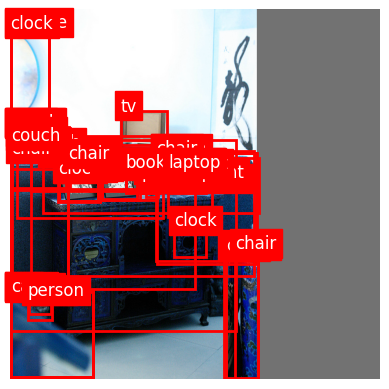

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from yolo_ev.module.data.dataset.coco.coco_classes import COCO_CLASSES

image = img[0].permute(1, 2, 0).cpu().numpy()
normalized_array = np.clip(image / np.max(image), 0, 1)
fig, ax = plt.subplots(1)
    # 画像を表示
ax.imshow(normalized_array)

t = processed_pred[0]
bboxes = t[:, 0:4].detach().numpy()
labels = t[:, 6]

# バウンディングボックスを描画
for bbox, label in zip(bboxes, labels):
    # バウンディングボックスの情報を取得 (cx, cy, w, h)
    x1, y1, x2, y2 = bbox
    w, h = x2 - x1, y2- y1
    # 左上の座標に変換 (x_min, y_min)
    
    # 四角形を描画
    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    # クラスラベルを表示
    class_name = COCO_CLASSES[int(label)]
    ax.text(x1, y1, class_name, color='white', fontsize=12, backgroundcolor='red')

plt.axis('off')
plt.show()

In [10]:
img.shape

torch.Size([1, 3, 640, 640])